# 목차
> ## 필요한 라이브러리 Import
> ## 데이터 다운로드 및 확인
> ## 데이터 시각화 및 전처리
> ## 모델 설계 및 학습
> ## 다른 종목에서 확인
> ## 회고

## 필요한 라이브러리 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

## 데이터 다운로드 및 확인

* 삼성의 주식데이터를 받아 5개만 확인해보겠습니다.

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

* 결측치를 확인하고 처리하겠습니다.

In [3]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

* 편차를 줄이기위해 로그함수를 이용하겠습니다.

In [4]:
# 로그 변환
ts_log = np.log(ts)

* 시각화 하기위한 함수를 만들겠습니다.

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

* window를 12로 줘서 대략 2주정도의 이동치를 확인하겠습니다.

* statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수를 사용하겠습니다.

In [6]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

* 시각화 해보겠습니다.

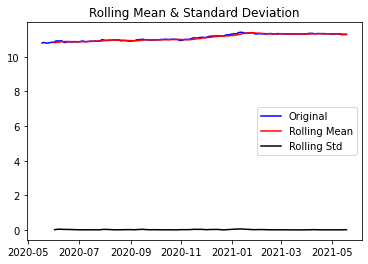

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


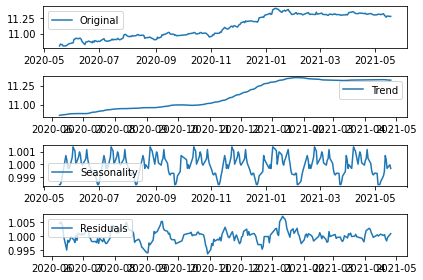

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* 평균과 분산은 안정적이지만 p-value 값이 높다고 볼수 있겠습니다. 그래서 Residuals값을 사용할 것인데 밑에서 확인해보겠습니다.

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


* p-value값이 0에 가까워 안정적 시계열입니다.

## 데이터 나누기

* 트레인 데이터와 테스트 데이터를 나눠보겠습니다.

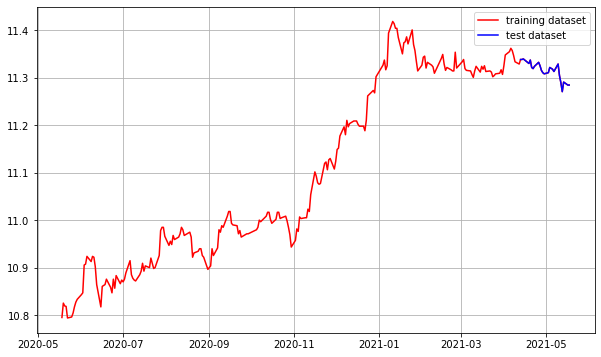

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* ACF, PACF 그려보기

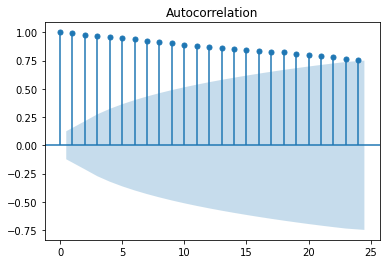

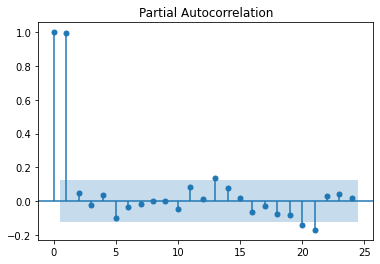

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* PACF를 보면 2이상부터 0에 가깝고, ACF를 보면 크게 의미가 있을것 같지 않습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


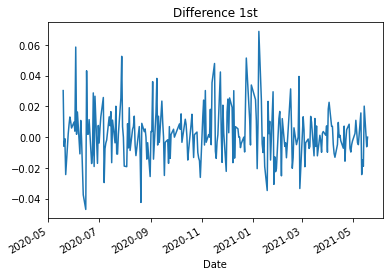

In [11]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

* ARIMA 학습전 1차분을 구해보았습니다. p-value값이 많이 낮아 2차분까지 안해도 될것 같습니다.

## auto_arima 사용하기

* 최적의 arima 변수를 계산해주는 함수를 쓰기 위해 라이브러리를 다운받고 사용해 보겠습니다.

In [12]:
!pip install pmdarima

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [13]:
from pmdarima import auto_arima

* 이 기능은 기본적으로 AIC 점수라는 것을 사용하여 특정 주문 모델이 얼마나 좋은지 판단합니다. 단순히 AIC 점수를 최소화하려고 시도하며 다음과 같은 결과가 표시됩니다.

In [14]:
auto_arima(train_data, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1159.385, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1164.726, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.746 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

* 사용해본 결과 (0. 1. 0)의 파라미터 학습을 권장하고 있습니다. 실제로 1차분만 해도 괜찮나보네요. 그대로 해보겠습니다.

In [15]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 585.365
Method:                           css   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1166.730
Time:                        05:58:48   BIC                          -1159.906
Sample:                             1   HQIC                         -1163.975
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.010      0.044    5.92e-05       0.005


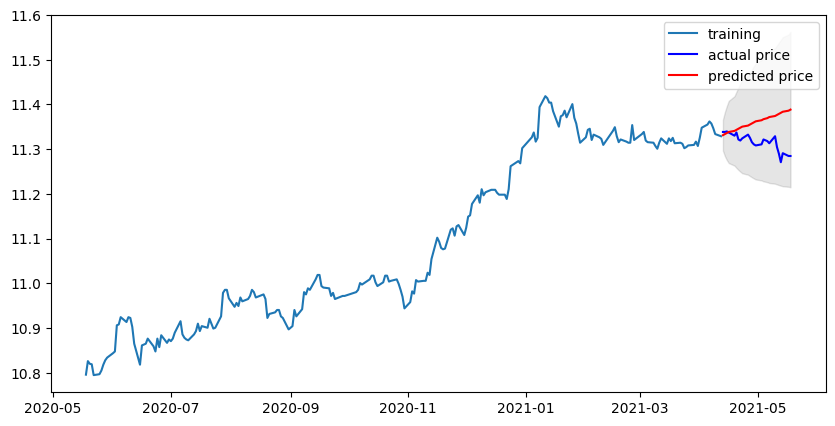

In [16]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

* 예측은 올라갔지만 실제론 떨어졌습니다.

In [17]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22147137.751086995
MAE:  3797.696275515896
RMSE:  4706.074558598386
MAPE: 4.69%


* 4.69%의 오차가 생겼습니다.

### NVDA 주가 데이터를 사용해 보겠습니다.

In [18]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-11-18    134.287506
2020-11-19    134.402496
2020-11-20    130.877502
2020-11-23    131.399994
2020-11-24    129.577499
Name: Close, dtype: float64

In [19]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [20]:
ts_log = np.log(ts)

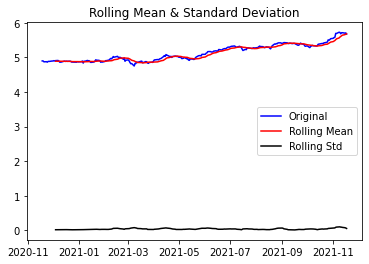

Results of Dickey-Fuller Test:
Test Statistic                   0.476725
p-value                          0.984148
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


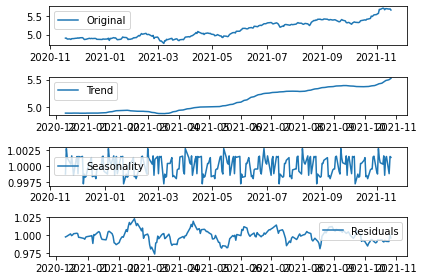

In [21]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* 앞에서 본 삼성과 비슷해 보입니다.

In [22]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.594940
p-value                          0.000132
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


* p-value의 값이 생각보단 높게 나왔네요 

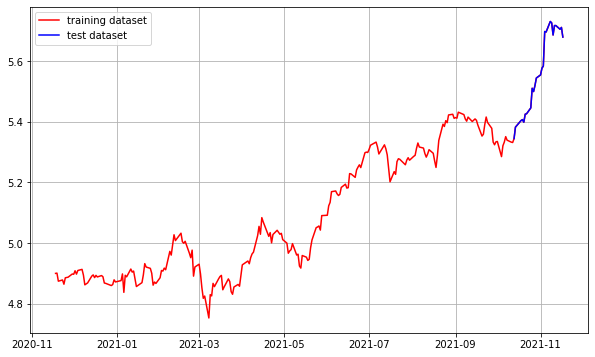

In [23]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* 데이터를 나눠 보았는데 갑자기 상승해서 이건 제대로 예측이 안될것 같은 불안감이 드네요.

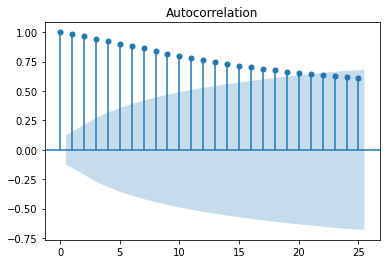

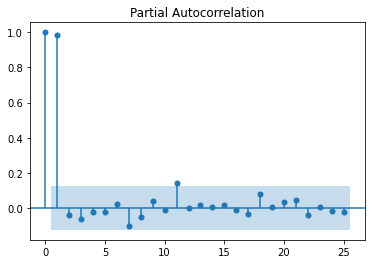

In [24]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.652644e+01
p-value                        2.042067e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


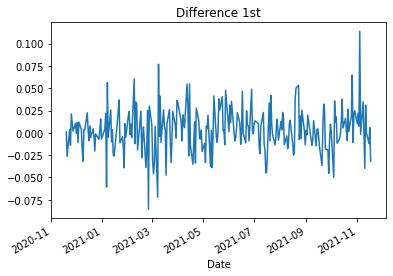

In [25]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [26]:
auto_arima(train_data, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1028.762, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1034.665, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1033.422, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1033.337, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1035.241, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.648 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

* 이번에도 (1, 0, 1)이 나왔네요. 그대로 해보겠습니다.

In [27]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 519.332
Method:                           css   S.D. of innovations              0.024
Date:                Thu, 18 Nov 2021   AIC                          -1034.665
Time:                        05:58:52   BIC                          -1027.833
Sample:                             1   HQIC                         -1031.907
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.195      0.232      -0.001       0.005


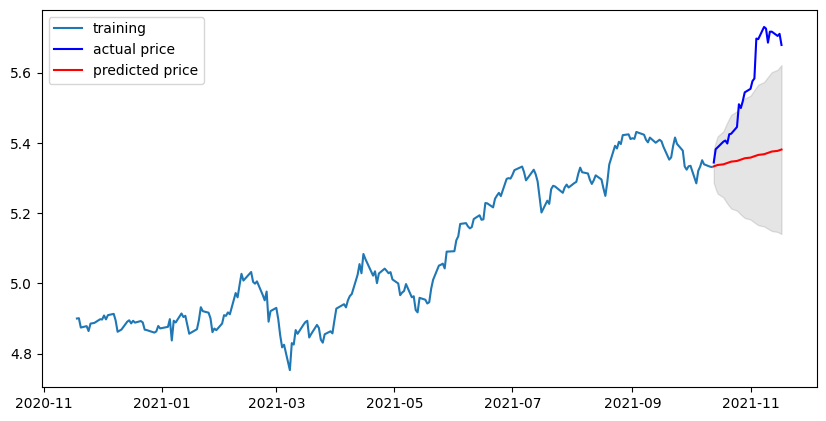

In [28]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

* 예상했던대로 예측은 많이 빗나갔습니다.

In [29]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3393.1613294542426
MAE:  48.998579994503785
RMSE:  58.250848315318486
MAPE: 17.48%


* 17% 이상의 오차가 발생했습니다. 이건 기계가 조금 억울할것 같아서 상승의 앞부분까진 학습할 수 있게 다시 데이터를 나눠보겠습니다.

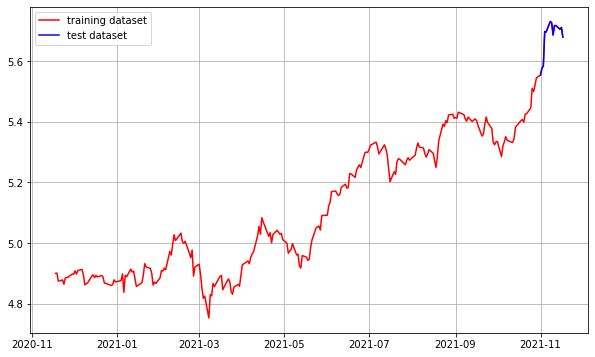

In [30]:
train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* 이번엔 상승하는 중이란걸 학습시켜서 조금 잘 될것 같습니다.

In [31]:
auto_arima(train_data, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1088.836, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1094.822, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1093.432, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1093.358, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1093.831, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1092.578, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.612 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

* 그대로 (0, 1, 0)을 사용해 보겠습니다.

In [32]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  238
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 549.411
Method:                           css   S.D. of innovations              0.024
Date:                Thu, 18 Nov 2021   AIC                          -1094.822
Time:                        05:58:53   BIC                          -1087.878
Sample:                             1   HQIC                         -1092.024
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.735      0.083      -0.000       0.006


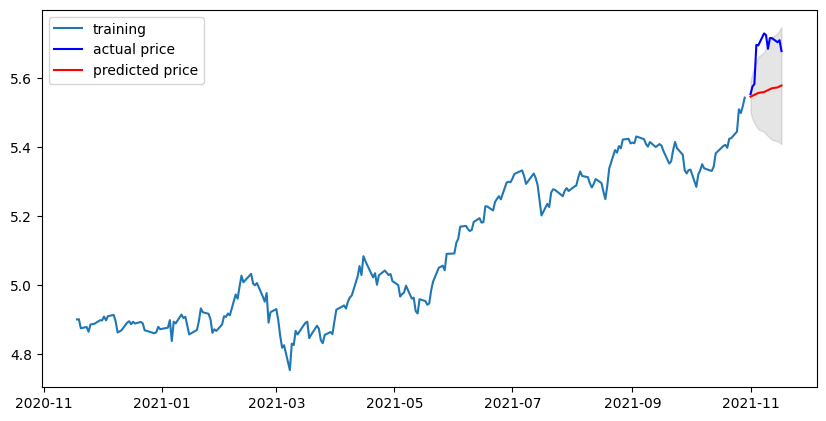

In [33]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

* 그렇게 만족스런 결과는 아니네요.

In [34]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1210.1455307488666
MAE:  31.40392398105828
RMSE:  34.78714605639368
MAPE: 10.48%


* 그래도 10.48%로 많이 줄었습니다.

### 디즈니 주가를 사용해 보겠습니다.

In [35]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/DIS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-11-18    143.899994
2020-11-19    141.720001
2020-11-20    141.070007
2020-11-23    145.979996
2020-11-24    151.490005
Name: Close, dtype: float64

In [36]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [37]:
ts_log = np.log(ts)

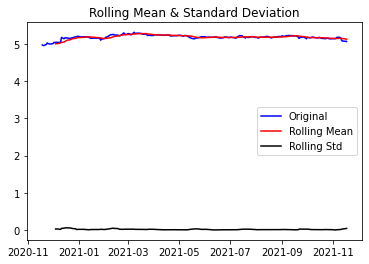

Results of Dickey-Fuller Test:
Test Statistic                  -3.270110
p-value                          0.016269
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


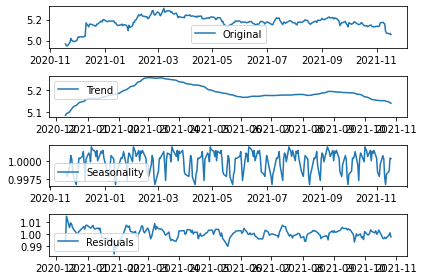

In [38]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [39]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.148943e+00
p-value                        7.645311e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


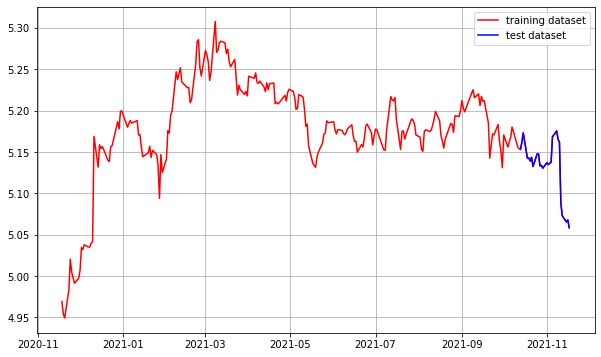

In [40]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* 앞에서는 너무 올라가서 걱정이였는데, 이번엔 너무 내려가 걱정입니다.

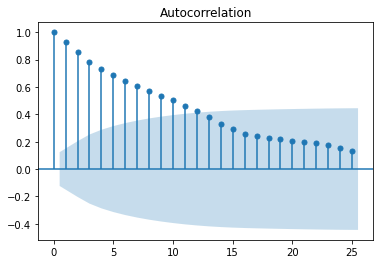

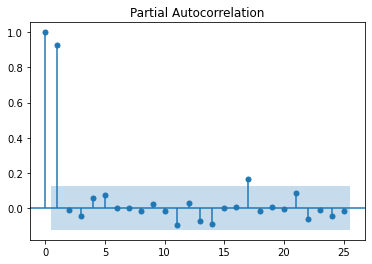

In [41]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [42]:
auto_arima(train_data, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1168.203, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1172.589, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1173.106, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1173.312, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1174.105, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1171.988, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.747 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

* 이번에도 (0, 1, 0)이네요. 좀 이상해서 다른 데이터를 넣어 봤는데 데이터마다 숫자가 바뀌는건 맞는것 같습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.704390e+01
p-value                        8.159622e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


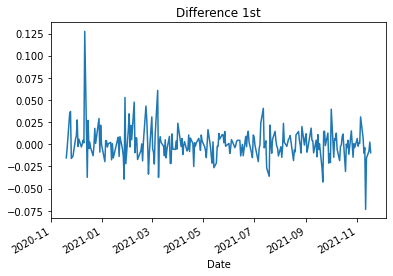

In [43]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [44]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 588.294
Method:                           css   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1172.589
Time:                        05:58:56   BIC                          -1165.757
Sample:                             1   HQIC                         -1169.831
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.696      0.486      -0.001       0.003


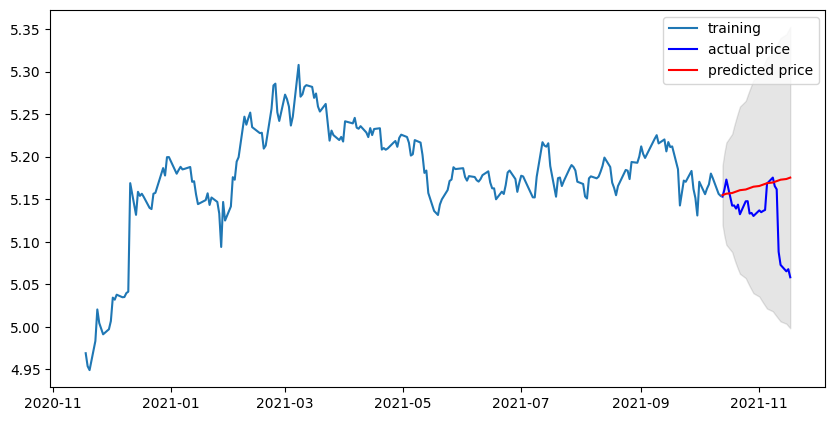

In [45]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

* 예상대로 많이 빗나가 보입니다.

In [46]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  69.10638218241853
MAE:  5.882133974431934
RMSE:  8.313024851545828
MAPE: 3.59%


* 그래도 3.59%로 많이 양호합니다.

## 회고
> 아무래도 3가지 종목이 모두 전체적으로 상승해서 학습된 데이터도 상승할거라고 예측한것 같습니다.<br/>
> auto_arima에 의존하지 않고 여러 파라미터를 넣어본 결과 오차를 줄이는 파라미터는 따로 있었습니다.<br/>오차만 고려하지 않고 여러가지를 종합해 판단하는게 아닌가 생각이 드네요.
> 이 모델로 주식을 하면 큰일날것 같습니다.